<a href="https://colab.research.google.com/github/rayyankayra/CreditcardSubscription/blob/main/Tugas_Mandiri_Data_Science_Project_4_Rayyan_Kaira_Paraditra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import itertools

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import (
    train_test_split, KFold, cross_val_score, GridSearchCV
)

from sklearn.preprocessing import (
    scale, LabelEncoder, StandardScaler,
    MinMaxScaler, Normalizer, RobustScaler
)

from sklearn.metrics import (
    classification_report, accuracy_score, f1_score,
    precision_score, confusion_matrix, recall_score,
    roc_auc_score, roc_curve
)

# to display all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# The number of numbers that will be shown after the comma.
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# 1.&nbsp;Load Dataset

## 1.1 Description

Data Set Story:
- It consists of 10000 observations and 12 variables.
- Independent variables contain information about customers.
- Dependent variable refers to customer abandonment.


Features:
- Surname: Surname
- CreditScore: Credit score
- Geography: Country (Germany / France / Spain)
- Gender: Gender (Female / Male)
- Age: Age
- Tenure: How many years of customer
- Balance: Balance
- NumOfProducts: Bank product used
- HasCrCard: Credit card status (0 = No, 1 = Yes)
- IsActiveMember: Active membership status (0 = No, 1 = Yes)
- EstimatedSalary: Estimated salary
- Exited: Abandoned or not? (0 = No, 1 = Yes)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Provide the path to your CSV file in Google Drive
file_path = '/content/drive/MyDrive/GreatEdu/churn_modeling_dataset.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv('/content/drive/MyDrive/GreatEdu/churn_modeling_dataset.csv', index_col=0)

NameError: name 'pd' is not defined

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
df['CustomerId'].nunique()

In [ ]:
labels = 'Churned', 'Retained'
sizes = [
    df.Exited[df['Exited']==1].count(),
    df.Exited[df['Exited']==0].count()
]

explode = (0, 0.1)
fig, ax = plt.subplots(figsize=(9, 7))
ax.pie(
    sizes, explode=explode,
    labels=labels, autopct='%1.1f%%',
    shadow=True, startangle=90
)
ax.axis('equal')
plt.title("Proportion of Customer Churned vs. Retained", size=20)
plt.show()

# 2.&nbsp;EDA


EDA stands for Exploratory Data Analysis. It's an approach to analyzing datasets to summarize their main characteristics, often using visual methods. The goal of EDA is to understand the data, detect patterns, identify anomalies, and formulate hypotheses that can be tested further. EDA typically involves techniques such as data visualization, summary statistics, and data cleaning.

Pada section ini, dilakukan dua tahap:
1. Data Preparation
2. Mengobservasi Outlier

## 2.1 Data Preparation

In [ ]:
dependent_variable_name = "Exited"

In [ ]:
def show_unique_count_variables(df):
    nunique_dict = {idx:[val] for idx, val in df.nunique().items()}
    df_nunique = pd.DataFrame(nunique_dict).T
    df_nunique.columns = ["unique_value_count"]
    display(df_nunique)

def data_prepare(df_raw_data):
    df_prep = df_raw_data.copy()

    missing_value_len = df.isnull().any().sum()
    if missing_value_len == 0:
        print("No Missing Value")
    else:
        print("Investigate Missing Value, Missing Value : " + str(missing_value_len))
    print("\n")

    show_unique_count_variables(df=df_prep)

    df_prep['Tenure'] = df_prep.Tenure.astype(float)
    df_prep['NumOfProducts'] = df_prep.NumOfProducts.astype(float)
    return df_prep

### 2.2. Outliers Observe (LOF method and Surpress)


#### 2.2.1. Outlier Editing

In [ ]:
def show_outliers(df):
    numerics = [
        'int16', 'int32', 'int64',
        'float16', 'float32', 'float64'
    ]

    df_num_cols = df.select_dtypes(include=numerics)

    sns.set(font_scale=0.7)
    fig, axes = plt.subplots(
        nrows=2, ncols=5,
        gridspec_kw=dict(hspace=0.3),
        figsize=(12, 9)
    )

    fig.tight_layout()
    for ax, col in zip(axes.flatten(), df_num_cols.columns):
        sns.boxplot(
            x=df_num_cols[col], color='green', ax=ax
        )

    fig.suptitle('Observing Outliers', color='r', fontsize=14)

#### Notes




The Local Outlier Factor (LOF) algorithm implemented in scikit-learn calculates the local density deviation of a given data point with respect to its neighbors. The negative_outlier_factor_ attribute in scikit-learn's LOF implementation contains the opposite LOF scores for each data point. Here's how you can interpret it:

1. Local Outlier Factor (LOF):
LOF values close to 1 indicate that the data point is similar in density to its neighbors.
LOF values significantly greater than 1 indicate that the data point is in a region of lower density compared to its neighbors, suggesting it may be an outlier.
The further the LOF value is from 1, the more anomalous the data point is considered.

2. Sign of the LOF:
The negative sign in negative_outlier_factor_ simply denotes that it's the "opposite" LOF, meaning the reciprocal of the LOF values. This is done for mathematical convenience.

3. Interpretation:
Higher negative values indicate higher outlier scores, suggesting stronger evidence of being an outlier.
Lower (less negative) values indicate data points that are less likely to be outliers.

4. Thresholding:
You can set a threshold to identify outliers. Data points with negative_outlier_factor_ below a certain threshold may be considered outliers.

5. Comparing Values:
You can compare the negative_outlier_factor_ values across different data points. Points with significantly lower values compared to others might be more likely to be outliers.

6. Visualization:
Visualizing the negative_outlier_factor_ values against the data points can help identify outliers. Points with exceptionally low (highly negative) values are potential outliers.

#### 2.2.2. Visualization of outliers according to the LOF method

Source:
1. [Link_1](https://scikit-learn.org/stable/auto_examples/neighbors/plot_lof_outlier_detection.html#:~:text=The%20Local%20Outlier%20Factor%20(LOF,lower%20density%20than%20their%20neighbors.)
2. [Link_2](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html#sklearn.neighbors.LocalOutlierFactor)

In [ ]:
def lof_observation(df):

    df_new = df.copy()

    # Select numeric columns
    numerics = [
        'int16', 'int32', 'int64',
        'float16', 'float32', 'float64'
    ]

    df_num_cols = df_new.select_dtypes(include=numerics)

    # Convert selected columns to float64
    df_outlier = df_num_cols.astype("float64")

    # Instantiate LOF model
    clf = LocalOutlierFactor(
        n_neighbors=20, contamination=0.1
    )

    # Fit model and get negative_outlier_factor
    clf.fit(df_outlier)
    np_scores = clf.negative_outlier_factor_
    print("")
    print("Sorted Outliers Score (Lowest 100):")
    print((np.sort(np_scores))[:100])
    print("")

    # Create DataFrame with sorted LOF scores
    scores_df = pd.DataFrame(
        np.sort(np_scores), columns=['LOF_Score']
    )

    # Plot LOF scores
    scores_df.plot(
        stacked=True,
        # xlim=[0, 50], # first 50 observations
        color='r',
        title='Visualization of outliers according to the LOF method',
        style='.-');

    # Determine threshold value
    th_val = -1.6  # Adjust as needed
    # h_val = np.percentile(np_scores, 0.5)

    # Identify outliers
    outliers = np_scores <= th_val

    # Drop outliers
    df_new = df_new.drop(df_outlier[outliers].index)

    return df_new


Sorted Outliers Score (Lowest 100):
[-3.08555878 -2.93472746 -2.84794485 -2.76659104 -2.6850911  -2.62052331
 -2.60962632 -2.58668518 -2.58413555 -2.51931412 -2.48271434 -2.37159865
 -2.37065285 -2.355955   -2.32588054 -2.10245281 -2.06452981 -2.05046445
 -1.95312565 -1.88343633 -1.76682867 -1.75518011 -1.75306602 -1.68547216
 -1.66616785 -1.65946618 -1.65692693 -1.63787941 -1.63556438 -1.60001244
 -1.5925949  -1.55424873 -1.55254456 -1.53014738 -1.52924071 -1.52530458
 -1.52498503 -1.52174212 -1.51586411 -1.51576939 -1.50046862 -1.4855679
 -1.45633923 -1.4526947  -1.44164203 -1.43302056 -1.42694854 -1.41758041
 -1.41211277 -1.40487556 -1.40353593 -1.38891118 -1.38739766 -1.38487442
 -1.3832952  -1.3764266  -1.3660788  -1.3659226  -1.36191449 -1.35913365
 -1.35870259 -1.35798801 -1.35212962 -1.35055547 -1.34781708 -1.34730944
 -1.34536188 -1.34387538 -1.3412761  -1.33954466 -1.33854032 -1.33746276
 -1.33265772 -1.33176715 -1.33116468 -1.33001482 -1.32487216 -1.32378787
 -1.32345934 -1

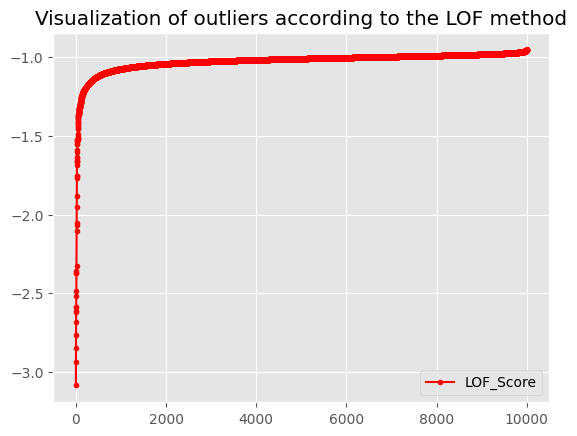

In [ ]:
_ = lof_observation(df) # Prohibit return df

#### 2.2.3. Outlier Suppression

In [ ]:
# def surpress_outlier(
#         df, feature_name, surpress_dir=["left", "right", "both"]):

#     Q1 = df[feature_name].quantile(0.25)
#     Q3 = df[feature_name].quantile(0.75)
#     IQR = Q3 - Q1
#     lower = Q1 - 1.5 * IQR
#     upper = Q3 + 1.5 * IQR
#     if surpress_dir == "left":
#         ...
#     elif:
#         ..
#     else:
#         ...

In [ ]:
def clear_outliers(df):

    # For Age
    Q1 = df["Age"].quantile(0.25)
    Q3 = df["Age"].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    print("Surpress 'Age' if,")
    print("below lower score:", lower)
    print("upper score:", upper)
    print("")
    df.loc[(df["Age"] > upper), "Age"] = upper

    # For Credit Score
    Q1 = df["CreditScore"].quantile(0.25)
    Q3 = df["CreditScore"].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    print("Surpress 'CreditScore' if,")
    print("below lower score:", lower)
    print("upper score:", upper)
    print("")
    df.loc[(df["CreditScore"] < lower), "CreditScore"] = lower
    return df

#### 2.2.4. Outlier Process

In [ ]:
def outlier_cleaning_process(df):
    df_clean = lof_observation(df=df)
    df_clean = clear_outliers(df=df_clean)
    return df_clean

### 2.3. Data Analysis
#### 2.3.1. Dependent variable distribution

In [ ]:
def show_dependent_variable(df):
    fig, axarr = plt.subplots(2, 3, figsize=(18, 6))
    sns.countplot(x='Geography', hue='Exited', data=df, ax=axarr[0][0])
    sns.countplot(x='Gender', hue='Exited', data=df, ax=axarr[0][1])
    sns.countplot(x='HasCrCard', hue='Exited', data=df, ax=axarr[0][2])
    sns.countplot(x='IsActiveMember', hue='Exited', data=df, ax=axarr[1][0])
    sns.countplot(x='NumOfProducts', hue='Exited', data=df, ax=axarr[1][1])
    sns.countplot(x='Tenure', hue='Exited', data=df, ax=axarr[1][2])
    zero, one = df[dependent_variable_name].value_counts()
    print("Dependent variable distribution;")
    print(dependent_variable_name + " 0 count:", zero)
    print(dependent_variable_name + " 1 count:", one)
    print("")

#### 2.3.2. Numeric columns distribution observation

In [ ]:
def show_numeric_columns_distributions(df):
    numerics = [
        'int16', 'int32', 'int64',
        'float16', 'float32', 'float64'
    ]
    df_num_cols = df.select_dtypes(include=numerics)
    columns = df_num_cols.columns[: len(df_num_cols.columns)]
    fig = plt.figure()
    fig.set_size_inches(18, 15)
    length = len(columns)
    for i,j in itertools.zip_longest(columns, range(length)):
        plt.subplot(int(length/2), 3, j+1)
        plt.subplots_adjust(wspace=0.2, hspace=0.5)
        df_num_cols[i].hist(bins=20, edgecolor='black')
        plt.title(i)
    fig = fig.suptitle('Structures of numeric variables', color='r', fontsize=18)
    plt.show()

#### 2.3.3. Status of other variables according to dependent variable

In [ ]:
def show_dependent_variable_cross_others_distributions(df):
    numerics = [
        'int16', 'int32', 'int64',
        'float16', 'float32', 'float64'
    ]
    df_dependent_var = df[df[dependent_variable_name]==1]
    df_num_cols = df_dependent_var.select_dtypes(include=numerics)
    columns = df_num_cols.columns[:len(df_num_cols.columns)]

    fig = plt.figure()
    fig.set_size_inches(18, 15)
    length = len(columns)
    for i,j in itertools.zip_longest(columns, range(length)):
        plt.subplot(int(length/2), 3, j+1)
        plt.subplots_adjust(wspace=0.2, hspace=0.5)
        df_num_cols[i].hist(bins=20, edgecolor='black')
        plt.title(i)
    fig = fig.suptitle(
        dependent_variable_name+'Status of other variables according to 1 dependent variable',
        color='r', fontsize=18)
    plt.show()

#### 2.3.4. Categorical variables are observed according to the dependent variable

In [ ]:
def show_dependent_variable_cross_categorical_distributions(df, categorical_columns):
    sns.set(font_scale=0.7)
    fig, axes = plt.subplots(
        nrows=int(len(categorical_columns)/2 ),
        ncols=2,
        figsize=(7,9)
    )
    fig.tight_layout()
    for ax,col in zip(axes.flatten(), categorical_columns):
        sns.countplot(
            x=df[col], hue=dependent_variable_name,
            data=df, ax=ax
        )
    fig.suptitle(
        'Categorical variables are monitored according to the dependent variable',
        color='r', fontsize=1
    )

#### 2.3.5. The main method that started all data analysis

In [ ]:
def show_data_analysis(df):
    show_dependent_variable(df)
    show_numeric_columns_distributions(df)
    show_dependent_variable_cross_others_distributions(df)
    show_dependent_variable_cross_categorical_distributions(
        df=df,
        categorical_columns=[
            "Gender", "Geography", "HasCrCard", "IsActiveMember"
        ]
    )

## 3.&nbsp;Feature Engineering

Feature engineering adalah proses menciptakan fitur baru atau mengubah fitur yang sudah ada dalam sebuah dataset untuk meningkatkan kinerja model pembelajaran mesin. Tujuan dari feature engineering adalah membuat data lebih informatif, lebih mudah diinterpretasikan, dan lebih cocok untuk model yang digunakan. Ini melibatkan pemilihan, modifikasi, atau penciptaan fitur yang menangkap pola dan hubungan yang ada dalam data secara lebih efektif.

In [ ]:
def credit_score_table(row):
    credit_score = row.CreditScore
    if credit_score < 300:
      return "Deep"
    elif 300 <= credit_score < 500:
        return "Very_Poor"
    elif 500 <= credit_score < 601:
        return "Poor"
    elif 601 <= credit_score < 661:
        return "Fair"
    elif 661 <= credit_score < 781:
        return "Good"
    elif 781 <= credit_score < 851:
        return "Excellent"
    else:
        return "Top"

### 3.1. Product utilization RATE by YEAR

In [ ]:
def product_utilization_rate_by_year(row):
    number_of_products = row.NumOfProducts
    tenure = row.Tenure

    if number_of_products == 0:
        return 0

    if tenure == 0:
        return number_of_products

    rate = number_of_products/tenure
    return rate

### 3.2. Product utilization RATE by estimated SALARY

In [ ]:
def product_utilization_rate_by_estimated_salary(row):
    number_of_products = row.number_of_products
    estimated_salary = row.EstimatedSalary

    if number_of_products == 0:
        return 0

    rate = number_of_products / estimated_salary
    return rate

### 3.3. According to countries monthly average salaries

reference: [Link](https://en.wikipedia.org/wiki/List_of_European_countries_by_average_wage)

In [ ]:
def countries_monthly_average_salaries(row):
    fr = 3696
    de = 4740
    sp = 2257
    salary = row.EstimatedSalary / 12
    country = row.Geography # Germany, France and Spain

    if country == 'Germany':
        return salary / de
    elif country == "France":
        return salary / fr
    elif country == "Spain":
        return salary / sp

### 3.4. The main method that started all Feature Engineering

In [ ]:
def feature_engineering(df, is_show_graph = False):
    df_fe = df.copy()

    balance_salary_rate = 'balance_salary_rate'
    df_fe[balance_salary_rate] = df_fe.Balance / df_fe.EstimatedSalary

    df_fe = df_fe.assign(
        product_utilization_rate_by_year=df_fe.apply(
            lambda x: product_utilization_rate_by_year(x),
            axis=1
            )
        )

    tenure_rate_by_age = 'tenure_rate_by_age'
    df_fe[tenure_rate_by_age] = df_fe.Tenure/(df_fe.Age - 17)

    credit_score_rate_by_age = 'credit_score_rate_by_age'
    df_fe[credit_score_rate_by_age] = df_fe.CreditScore/(df_fe.Age - 17)

    product_utilization_rate_by_salary = 'product_utilization_rate_by_salary'

    credit_score_rate_by_salary = 'credit_score_rate_by_salary'
    df_fe[credit_score_rate_by_salary] = df_fe.CreditScore/(df_fe.EstimatedSalary)

    if is_show_graph:
        fig, axes = plt.subplots(
            nrows=2, ncols=2, figsize=(20,12))
        fig.tight_layout()
        sns.boxplot(
            y=balance_salary_rate,
            x=dependent_variable_name,
            hue=dependent_variable_name,
            data=df_fe,
            ax=axes[0][0]
        )
        sns.boxplot(
            y=product_utilization_rate_by_year,
            x=dependent_variable_name,
            hue=dependent_variable_name,
            data=df_fe,
            ax=axes[0][1]
        )
        plt.ylim(-1, 5)

    df_fe = df_fe.assign(credit_score_table=df_fe.apply(lambda x: credit_score_table(x), axis=1))
    df_fe = df_fe.assign(countries_monthly_average_salaries=df_fe.apply(lambda x: countries_monthly_average_salaries(x), axis=1))
    return df_fe

# 4.&nbsp;Data Encoding

In [ ]:
def data_encoding(df):

    df_model = df.copy()

    # >>>> Categorical columns <<<<<
    non_encoding_columns = [
        "Geography", "HasCrCard","IsActiveMember",
        "Gender", "NumOfProducts", "Tenure", "credit_score_table"]

    df_non_encoding = df_model[non_encoding_columns]
    df_model = df_model.drop(non_encoding_columns, axis=1)
    df_encoding = df_non_encoding.copy()

    encoder = LabelEncoder()
    df_encoding["gender_category"] = encoder.fit_transform(df_non_encoding.Gender)
    df_encoding["country_category"] = encoder.fit_transform(df_non_encoding.Geography)
    df_encoding["credit_score_category"] = encoder.fit_transform(df_non_encoding.credit_score_table)

    df_encoding.reset_index(drop=True, inplace=True)
    df_model.reset_index(drop=True, inplace=True)
    df_model = pd.concat([df_model, df_encoding], axis=1)

    df_model = df_model.drop(
        ["Geography", "Gender" , "CustomerId", "Surname",
         "credit_score_table", "CreditScore", "EstimatedSalary"],
        axis=1)

    df_model = df_model.reset_index()
    df_model = df_model.drop('index', axis=1)

    df_model.loc[df_model.HasCrCard==0, 'credit_card_situation'] = -1
    df_model.loc[df_model.IsActiveMember==0, 'is_active_member'] = -1
    return df_model

In [ ]:
df[df.IsActiveMember==0]["Exited"].value_counts()

Exited
0    3547
1    1302
Name: count, dtype: int64

In [ ]:
df[df.IsActiveMember==0]["Exited"].value_counts(normalize=True)

Exited
0   0.73
1   0.27
Name: proportion, dtype: float64

# 5.&nbsp;Model Preparation

In [ ]:
def model_prepare(df_model):

    X = df_model.loc[:, df_model.columns != dependent_variable_name]
    y = df_model[dependent_variable_name]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test

### 5.1 Part of Data Train

In [ ]:
def data_training(X_train, X_test, y_train, y_test):

    models = []
    models.append(('LOGR', LogisticRegression()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('RF', RandomForestClassifier()))
    models.append(('GBM', GradientBoostingClassifier()))
    models.append(('XGBoost', XGBClassifier()))
    models.append(('LightGBM', LGBMClassifier()))

    res_cols = [
        'model', 'accuracy_score', 'scale_method',
        "0_precision", "0_recall", "1_precision", "1_recall"
    ]

    df_result = pd.DataFrame(columns=res_cols)

    index = 0
    for name, model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        class_report = classification_report(y_test, y_pred, digits=2, output_dict=True)
        zero_report = class_report['0']
        one_report = class_report['1']
        res_vals = [
            name, score, "NA",
            zero_report['precision'], zero_report['recall'],
            one_report['precision'], one_report['recall']
        ]
        df_result.at[index, res_cols] = res_vals
        index += 1
    return df_result.sort_values("accuracy_score", ascending=False)

# 6.&nbsp;HELPER Functions

In [ ]:
# Function to give best model score and parameters

def best_model(model):
    print(model.best_score_)
    print(model.best_params_)
    print(model.best_estimator_)

def get_auc_scores(y_actual, method,method2):
    auc_score = roc_auc_score(y_actual, method);
    fpr_df, tpr_df, _ = roc_curve(y_actual, method2);
    return (auc_score, fpr_df, tpr_df)

from matplotlib import rc, rcParams
def plot_confusion_matrix(
    cm, classes, normalize=False,
    title='Confusion Matrix', cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)
    plt.rcParams.update({'font.size': 16})
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, color="blue")
    plt.yticks(tick_marks, classes, color="blue")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="red" if cm[i, j] > thresh else "black"
        )

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# 7.&nbsp;Data Cleaning

No Missing Value




,unique_value_count
CustomerId,10000
Surname,2932
CreditScore,460
Geography,3
Gender,2
Age,70
Tenure,11
Balance,6382
NumOfProducts,4
HasCrCard,2



Sorted Outliers Score (Lowest 100):
[-3.08555878 -2.93472746 -2.84794485 -2.76659104 -2.6850911  -2.62052331
 -2.60962632 -2.58668518 -2.58413555 -2.51931412 -2.48271434 -2.37159865
 -2.37065285 -2.355955   -2.32588054 -2.10245281 -2.06452981 -2.05046445
 -1.95312565 -1.88343633 -1.76682867 -1.75518011 -1.75306602 -1.68547216
 -1.66616785 -1.65946618 -1.65692693 -1.63787941 -1.63556438 -1.60001244
 -1.5925949  -1.55424873 -1.55254456 -1.53014738 -1.52924071 -1.52530458
 -1.52498503 -1.52174212 -1.51586411 -1.51576939 -1.50046862 -1.4855679
 -1.45633923 -1.4526947  -1.44164203 -1.43302056 -1.42694854 -1.41758041
 -1.41211277 -1.40487556 -1.40353593 -1.38891118 -1.38739766 -1.38487442
 -1.3832952  -1.3764266  -1.3660788  -1.3659226  -1.36191449 -1.35913365
 -1.35870259 -1.35798801 -1.35212962 -1.35055547 -1.34781708 -1.34730944
 -1.34536188 -1.34387538 -1.3412761  -1.33954466 -1.33854032 -1.33746276
 -1.33265772 -1.33176715 -1.33116468 -1.33001482 -1.32487216 -1.32378787
 -1.32345934 -1

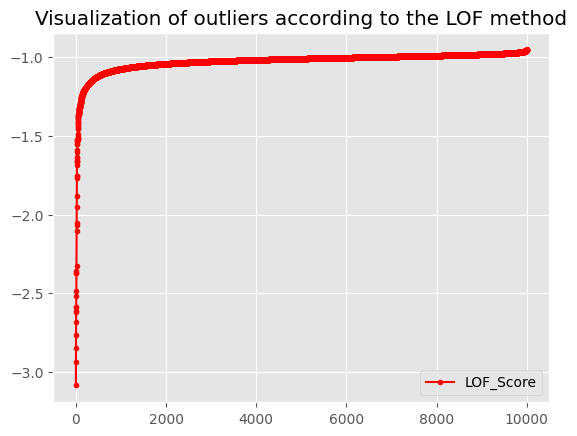

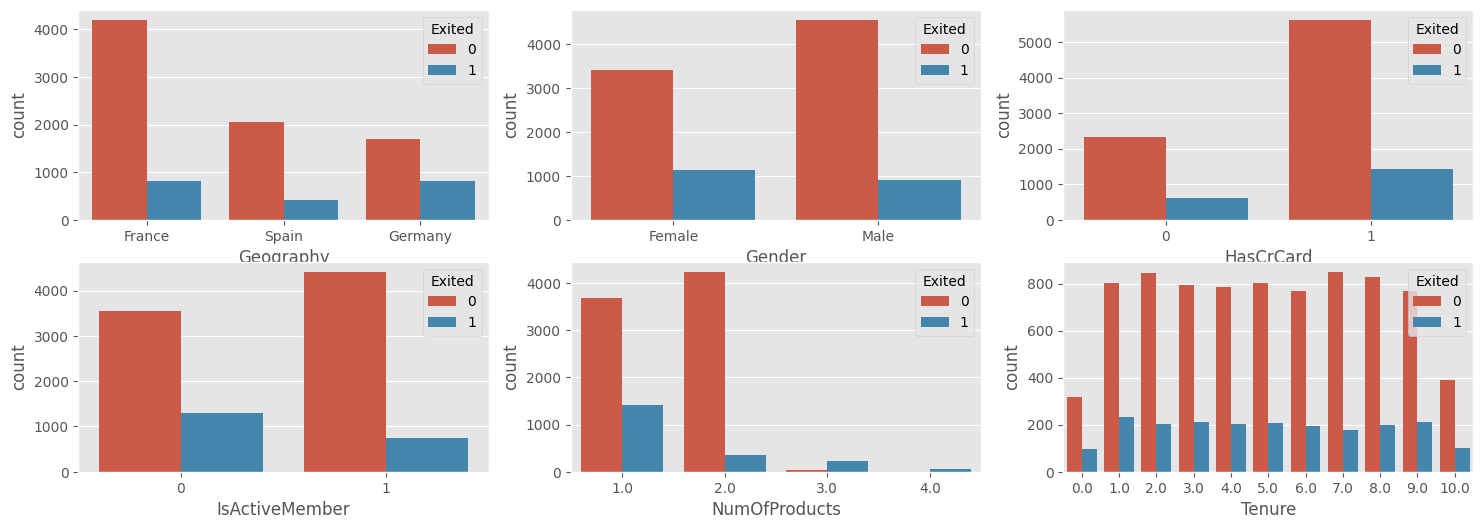

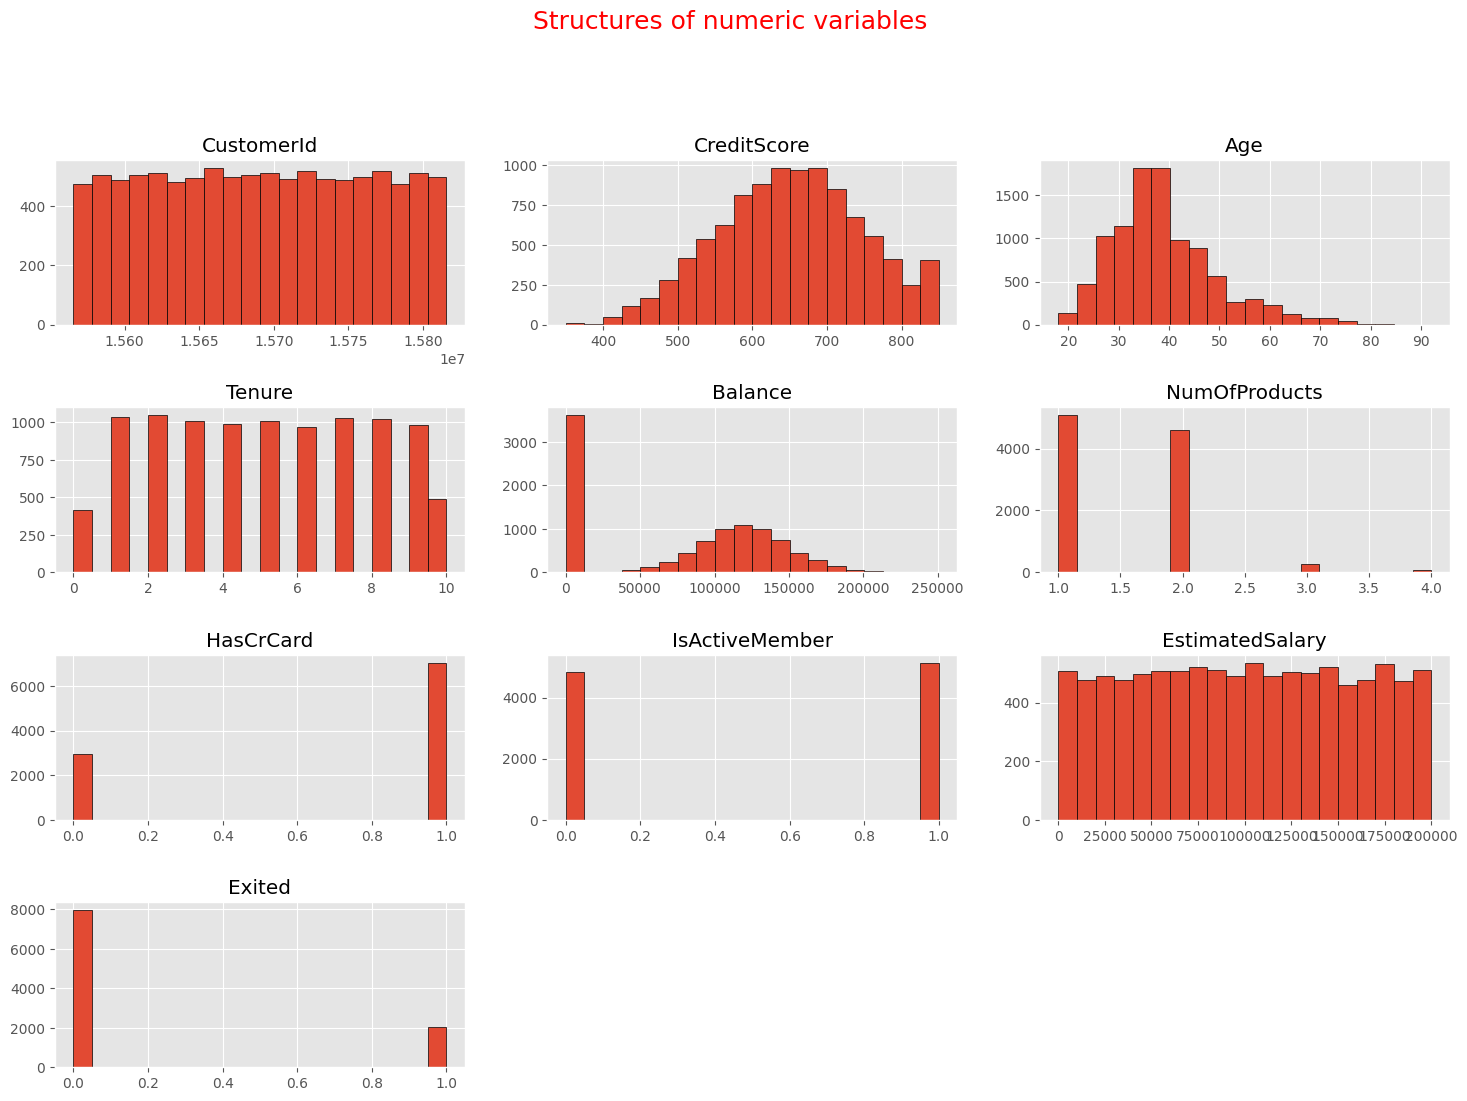

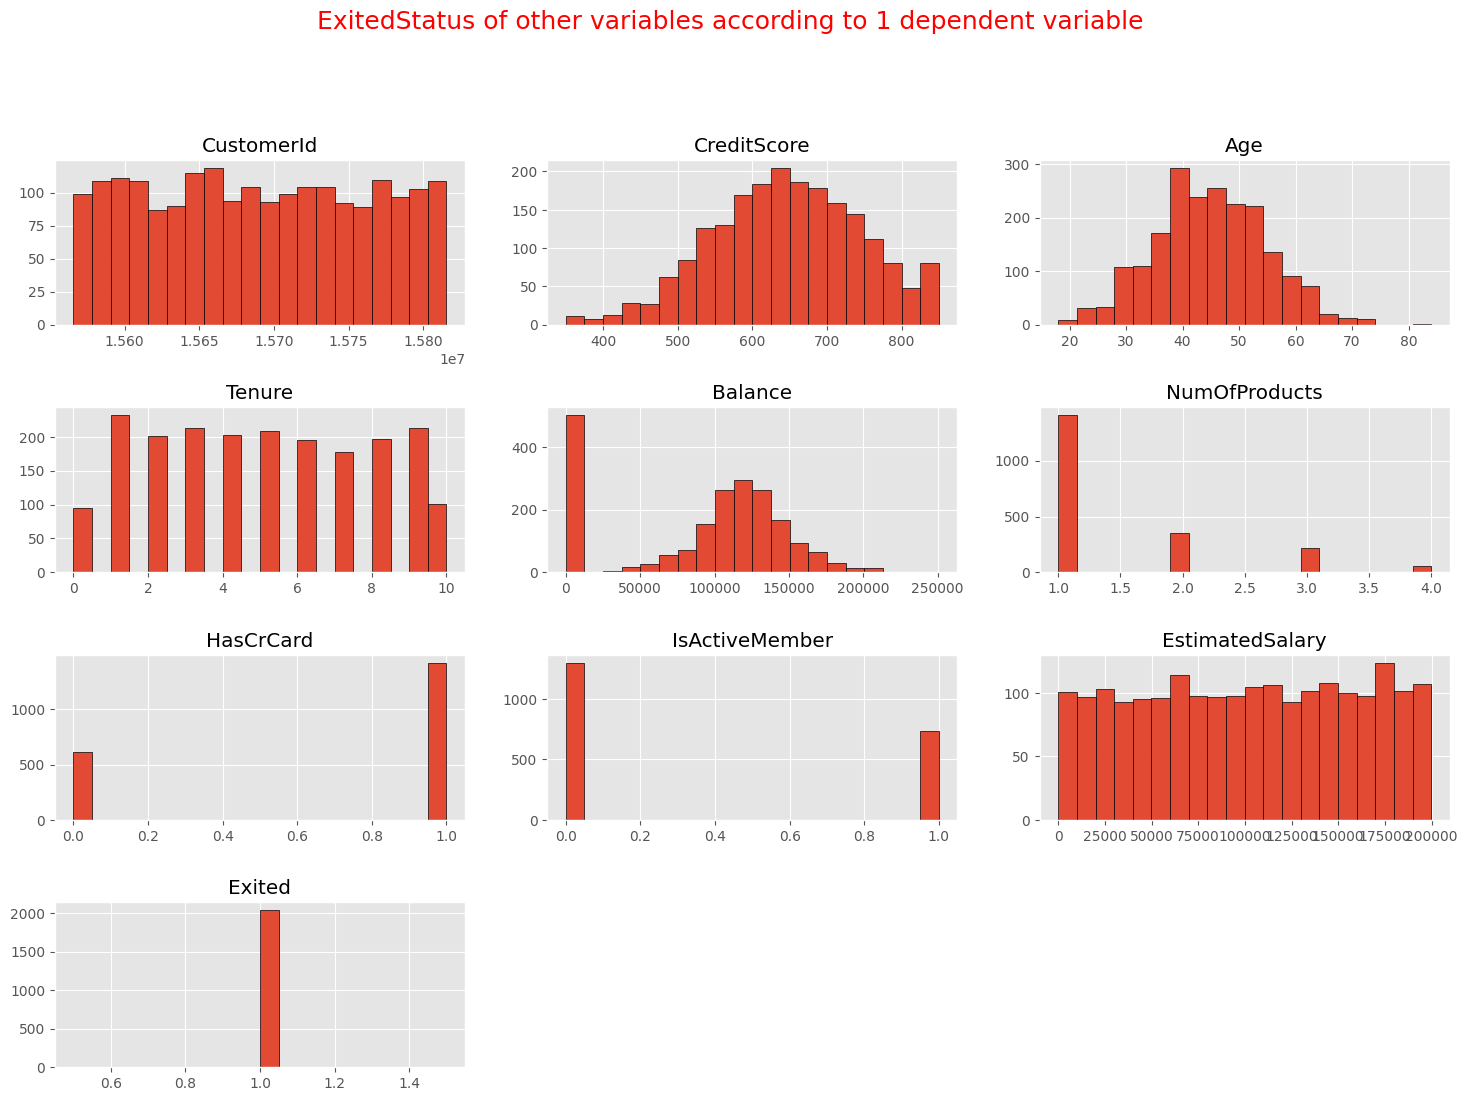

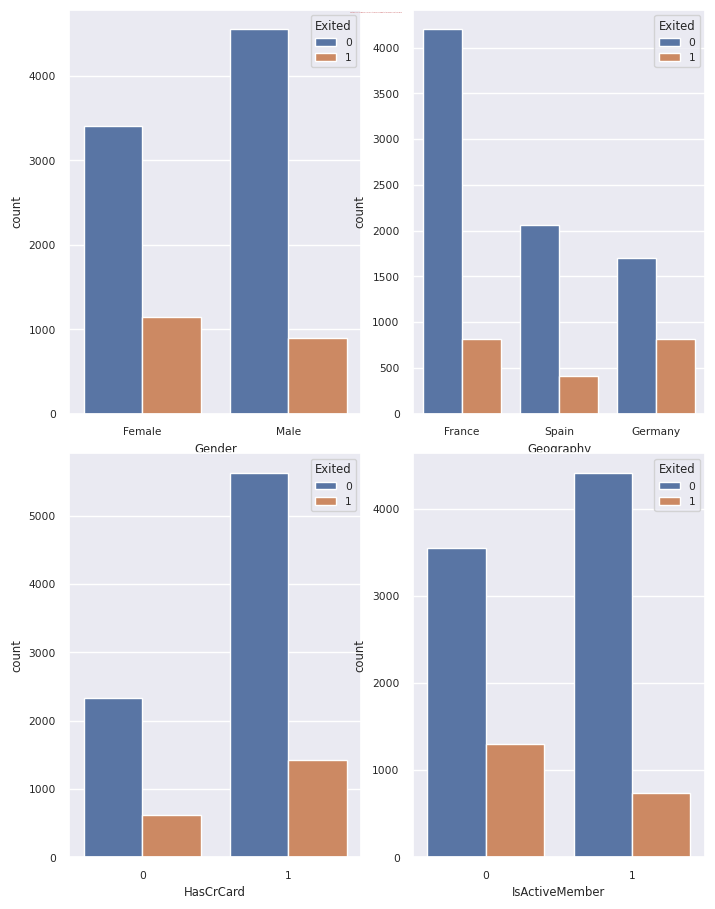

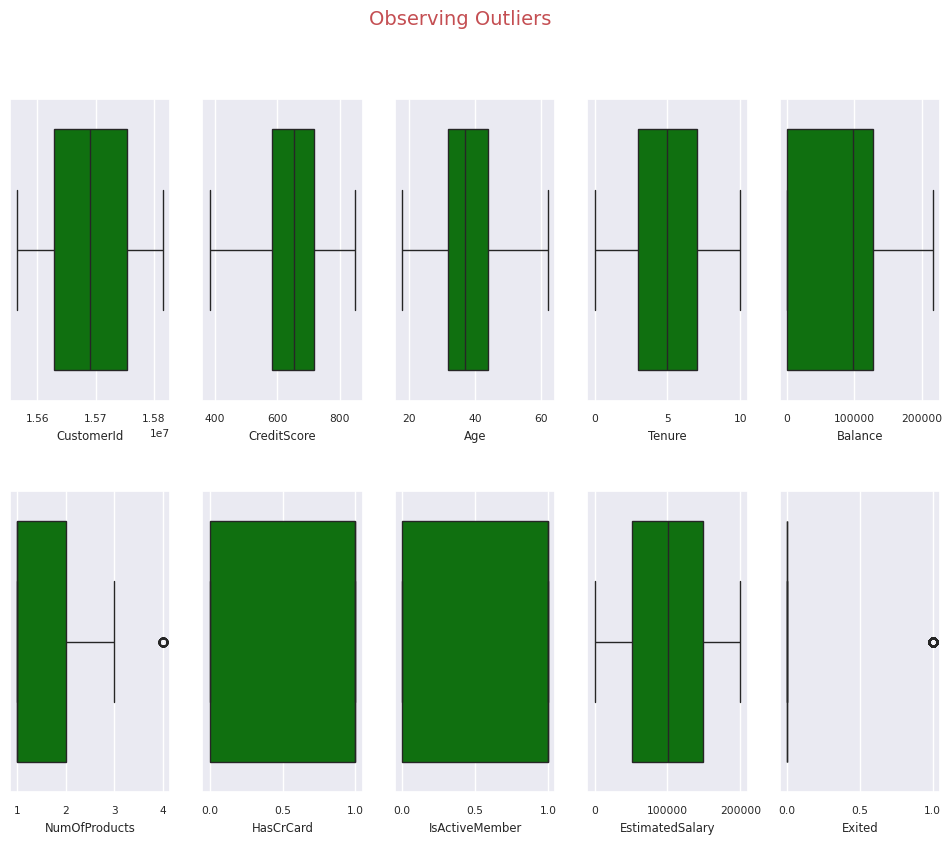

In [ ]:
df_prep = data_prepare(df)
df_outlier = outlier_cleaning_process(df=df_prep)

show_data_analysis(df_prep)
show_outliers(df=df_outlier)

Let's see after feature engineering:

In [ ]:
df_fe = feature_engineering(df=df_outlier)
df_fe.head(3)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,balance_salary_rate,product_utilization_rate_by_year,tenure_rate_by_age,credit_score_rate_by_age,credit_score_rate_by_salary,credit_score_table,countries_monthly_average_salaries
RowNumber,,,,,,,,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2.00,0.00,1.00,1,1,101348.88,1,0.00,0.50,0.08,24.76,0.01,Fair,2.29
2,15647311,Hill,608,Spain,Female,41,1.00,83807.86,1.00,0,1,112542.58,0,0.74,1.00,0.04,25.33,0.01,Fair,4.16
3,15619304,Onio,502,France,Female,42,8.00,159660.80,3.00,1,0,113931.57,1,1.40,0.38,0.32,20.08,0.00,Poor,2.57


And see after data encoding:

In [ ]:
df_encoded = data_encoding(df_fe)
df_encoded.drop(
    columns=['credit_card_situation', 'is_active_member'],
    inplace=True
)
df_encoded.head(5)

,Age,Balance,Exited,balance_salary_rate,product_utilization_rate_by_year,tenure_rate_by_age,credit_score_rate_by_age,credit_score_rate_by_salary,countries_monthly_average_salaries,HasCrCard,IsActiveMember,NumOfProducts,Tenure,gender_category,country_category,credit_score_category
0,42,0.00,1,0.00,0.50,0.08,24.76,0.01,2.29,1,1,1.00,2.00,0,0,1
1,41,83807.86,0,0.74,1.00,0.04,25.33,0.01,4.16,0,1,1.00,1.00,0,2,1
2,42,159660.80,1,1.40,0.38,0.32,20.08,0.00,2.57,1,0,3.00,8.00,0,0,3
3,39,0.00,0,0.00,2.00,0.05,31.77,0.01,2.12,0,0,2.00,1.00,0,0,2
4,43,125510.82,0,1.59,0.50,0.08,32.69,0.01,2.92,1,1,1.00,2.00,0,2,0


Now, let's see correlation graph:

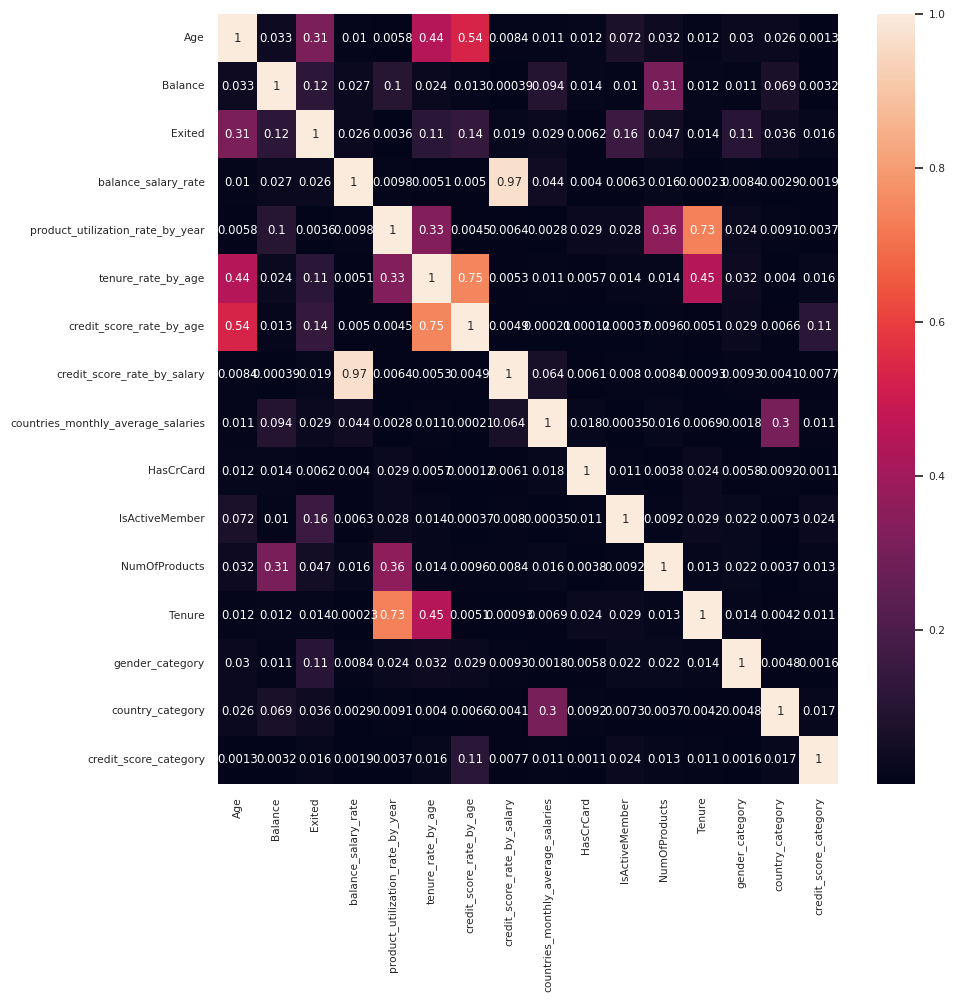

In [ ]:
correlation = df_encoded.corr().abs()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation, annot=True)
plt.show()

List of correlation scores:

In [ ]:
corrs_results = df_encoded.corrwith(df_encoded["Exited"]).abs().nlargest(24)
corrs_results

Exited                               1.00
Age                                  0.31
IsActiveMember                       0.16
credit_score_rate_by_age             0.14
Balance                              0.12
tenure_rate_by_age                   0.11
gender_category                      0.11
NumOfProducts                        0.05
country_category                     0.04
countries_monthly_average_salaries   0.03
balance_salary_rate                  0.03
credit_score_rate_by_salary          0.02
credit_score_category                0.02
Tenure                               0.01
HasCrCard                            0.01
product_utilization_rate_by_year     0.00
dtype: float64

# 8.&nbsp;Apply Model

In [ ]:
# model_prepare test, train split 0.2
X_train, X_test, y_train, y_test = model_prepare(df_model=df_encoded)

### 8.1. Logistic Regression Model

Have a look with Logistic Regression.

In [ ]:
logr_model = LogisticRegression()
logr_model.fit(X_train, y_train)
y_pred = logr_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(classification_report(y_test, y_pred, digits=4))
print("Accuracy score of Logistic Regression: ", accuracy)

              precision    recall  f1-score   support

           0     0.8398    0.9687    0.8997      1597
           1     0.6711    0.2569    0.3716       397

    accuracy                         0.8270      1994
   macro avg     0.7555    0.6128    0.6356      1994
weighted avg     0.8062    0.8270    0.7945      1994

Accuracy score of Logistic Regression:  0.8269809428284854


### 8.2. Model Training

This is for all LogisticRegression, RandomForestClassifier, GradientBoostingClassifier, XGBClassifier, and LGBMClassifier model objects:

In [ ]:
def data_training(X_train, X_test, y_train, y_test):

    models = []
    models.append(('LOGR', LogisticRegression()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('RF', RandomForestClassifier()))
    models.append(('GBM', GradientBoostingClassifier()))
    models.append(('XGBoost', XGBClassifier()))
    models.append(('LightGBM', LGBMClassifier()))

    res_cols = ["model", "accuracy_score", "scale_method", "0_precision", "0_recall", "1_precision", "1_recall"]
    df_result = pd.DataFrame(columns=res_cols)
    index = 0
    for name, model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        class_report = classification_report(y_test, y_pred, digits=2, output_dict=True)
        zero_report = class_report['0']
        one_report = class_report['1']

        idx_res_values = [name, score, "NA", zero_report['precision'], zero_report['recall'], one_report['precision'], one_report['recall']]
        # df_result.at[index, res_cols] = idx_res_values
        df_result.loc[index, res_cols] = idx_res_values
        index += 1
    df_result = df_result.sort_values("accuracy_score", ascending=False).reset_index(drop=True)
    return df_result

In [ ]:
training_result = data_training(X_train, X_test, y_train, y_test)
training_result

[LightGBM] [Info] Number of positive: 1627, number of negative: 6349
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1625
[LightGBM] [Info] Number of data points in the train set: 7976, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203987 -> initscore=-1.361559
[LightGBM] [Info] Start training from score -1.361559


,model,accuracy_score,scale_method,0_precision,0_recall,1_precision,1_recall
0,LightGBM,0.86,NA,0.88,0.96,0.74,0.48
1,RF,0.86,NA,0.87,0.96,0.76,0.44
2,GBM,0.86,NA,0.88,0.96,0.75,0.45
3,XGBoost,0.85,NA,0.88,0.94,0.66,0.48
4,KNN,0.84,NA,0.86,0.95,0.65,0.39
5,LOGR,0.83,NA,0.84,0.97,0.67,0.26
6,CART,0.78,NA,0.86,0.87,0.46,0.46


# 9.&nbsp;Model Tuning

### 9.1. XGBoost Tuning

In [ ]:
xgb_model=XGBClassifier(
    learning_rate=0.23,
    max_delta_step=5,
    objective='reg:logistic',
    n_estimators=92,
    max_depth=5,
    eval_metric="logloss",
    gamma=3,
    base_score=0.5
)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
recall = recall_score(y_test, y_pred)
false_negatives = sum((y_test == 1) & (y_pred == 0))
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=2))
print("Recall Score:", recall)
print("Jumlah False Negative:", false_negatives)
print("Accuracy score of Tuned XGBoost Regression: ", accuracy_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1607
           1       0.74      0.47      0.58       393

    accuracy                           0.86      2000
   macro avg       0.81      0.72      0.75      2000
weighted avg       0.85      0.86      0.85      2000

Recall Score: 0.4732824427480916
Jumlah False Negative: 207
Accuracy score of Tuned XGBoost Regression:  0.8635


### 9.2. Random Forest Tuning

In [ ]:
'''
param_grid = {
    'max_depth': [3, 5, 6, 7, 8],
    'max_features': [2, 4, 6, 7, 8, 9],
    'n_estimators' : [50, 100],
    'min_samples_split': [3, 5, 6, 7]
}

randFor_grid = GridSearchCV(
    RandomForestClassifier(),
    param_grid, cv=5,
    refit=True, verbose=0
)

randFor_grid.fit(X_train, y_train)
best_model(randFor_grid)
'''

# skipped, running too long

"\nparam_grid = {\n    'max_depth': [3, 5, 6, 7, 8],\n    'max_features': [2, 4, 6, 7, 8, 9],\n    'n_estimators' : [50, 100],\n    'min_samples_split': [3, 5, 6, 7]\n}\n\nrandFor_grid = GridSearchCV(\n    RandomForestClassifier(),\n    param_grid, cv=5,\n    refit=True, verbose=0\n)\n\nrandFor_grid.fit(X_train, y_train)\nbest_model(randFor_grid)\n"

Using the parameters and get final version accuracy score.

In [ ]:
rnd_model = RandomForestClassifier(
    max_depth=8,
    max_features=6,
    min_samples_split=6,
    n_estimators=50
)

rnd_model.fit(X_train, y_train)
y_pred = rnd_model.predict(X_test)
recall = recall_score(y_test, y_pred)
false_negatives = sum((y_test == 1) & (y_pred == 0))
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=2))
print("Accuracy score of tuned Random Forest model: ", accuracy_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1607
           1       0.76      0.47      0.58       393

    accuracy                           0.87      2000
   macro avg       0.82      0.72      0.75      2000
weighted avg       0.86      0.87      0.85      2000

Accuracy score of tuned Random Forest model:  0.866


### 9.3. LightGBM Tuning

In [ ]:
lgbm_model = LGBMClassifier(
    silent = 0,
    learning_rate = 0.09,
    max_delta_step = 2,
    n_estimators = 100,
    boosting_type = 'gbdt',
    max_depth = 10,
    eval_metric = "logloss",
    gamma = 3,
    base_score = 0.5
)

lgbm_model.fit(X_train, y_train)
y_pred = lgbm_model.predict(X_test)
recall = recall_score(y_test, y_pred)
false_negatives = sum((y_test == 1) & (y_pred == 0))
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=2))
print("Accuracy score of tuned LightGBM model: ", accuracy_score(y_test, y_pred))

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: base_score
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: base_score
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1644, number of negative: 6356
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 857
[LightGBM] [Info] Number of data points in the train set: 8000, number of used featu

# 10.&nbsp;Confusion Matrix

Confusion matrix, without normalization
True Negatives:  1537
False Positives:  70
False Negatives:  199
True Positives:  194


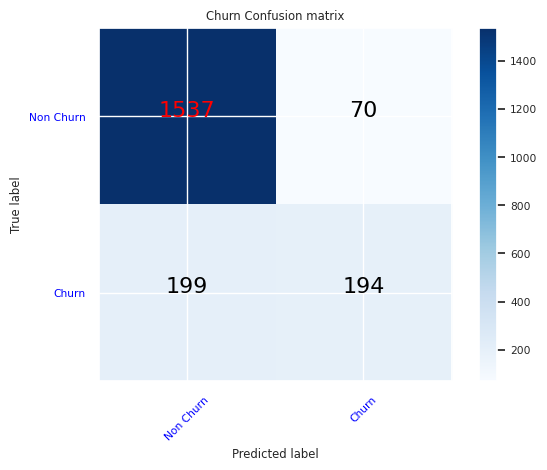

In [ ]:
cfm = confusion_matrix(y_test, y_pred=y_pred)
plot_confusion_matrix(
    cfm,
    normalize=False,
    classes=['Non Churn','Churn'],
    title='Churn Confusion matrix'
)

tn, fp, fn, tp = cfm.ravel()

print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

# Confusion Matrix XGB, LGBM, RNF

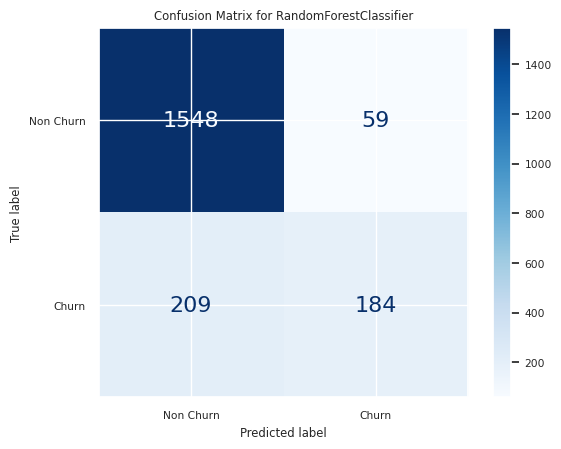

True Negatives (RandomForestClassifier): 1548
False Positives (RandomForestClassifier): 59
False Negatives (RandomForestClassifier): 209
True Positives (RandomForestClassifier): 184

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: base_score
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


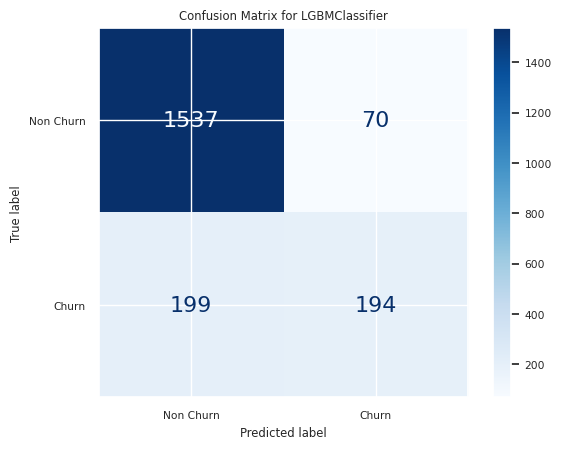

True Negatives (LGBMClassifier): 1537
False Positives (LGBMClassifier): 70
False Negatives (LGBMClassifier): 199
True Positives (LGBMClassifier): 194



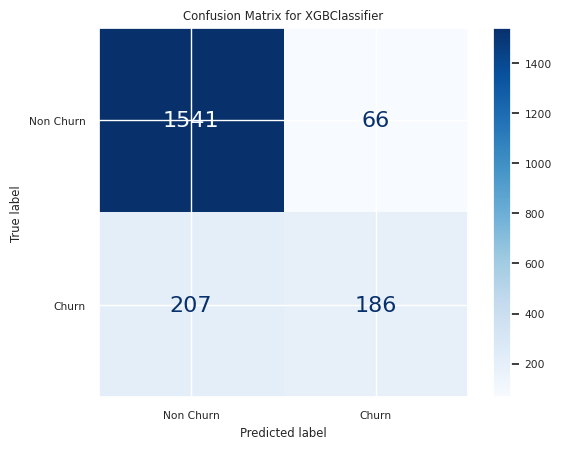

True Negatives (XGBClassifier): 1541
False Positives (XGBClassifier): 66
False Negatives (XGBClassifier): 207
True Positives (XGBClassifier): 186



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Fungsi untuk menampilkan confusion matrix, mendapatkan nilai TN, FP, FN, TP, dan menampilkan nilai-nilai tersebut
def display_confusion_matrix(model, X_test, y_test, model_name):
    # Mendapatkan prediksi dari model
    y_pred = model.predict(X_test)
    # Menghitung confusion matrix
    cfm = confusion_matrix(y_test, y_pred)
    # Menampilkan confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cfm, display_labels=['Non Churn', 'Churn'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()
    # Mendapatkan nilai TN, FP, FN, TP
    tn, fp, fn, tp = cfm.ravel()
    # Menampilkan nilai-nilai tersebut
    print(f"True Negatives ({model_name}):", tn)
    print(f"False Positives ({model_name}):", fp)
    print(f"False Negatives ({model_name}):", fn)
    print(f"True Positives ({model_name}):", tp)
    print()

# Menampilkan confusion matrix, mendapatkan nilai TN, FP, FN, TP, dan menampilkan nilai-nilai tersebut untuk model RandomForestClassifier
display_confusion_matrix(rnd_model, X_test, y_test, 'RandomForestClassifier')

# Menampilkan confusion matrix, mendapatkan nilai TN, FP, FN, TP, dan menampilkan nilai-nilai tersebut untuk model LGBMClassifier
display_confusion_matrix(lgbm_model, X_test, y_test, 'LGBMClassifier')

# Menampilkan confusion matrix, mendapatkan nilai TN, FP, FN, TP, dan menampilkan nilai-nilai tersebut untuk model XGBClassifier
display_confusion_matrix(xgb_model, X_test, y_test, 'XGBClassifier')

# 11.&nbsp;ROC Curve

In [ ]:
!pip install scikit-plot

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: base_score
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


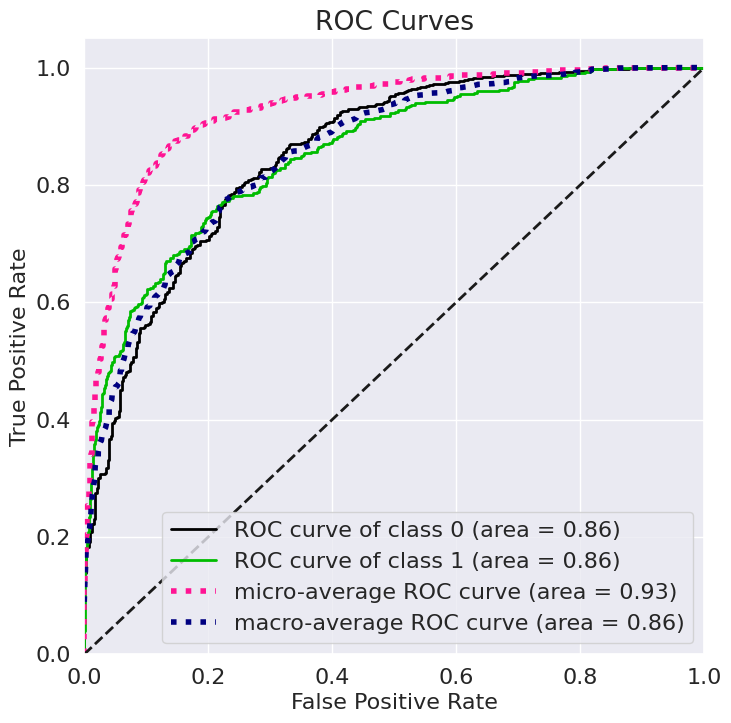

In [ ]:
import scikitplot as skplt
y_pred_proba = lgbm_model.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_test, y_pred_proba, figsize=(8,8))

plt.show()

# 12.&nbsp;Feature Importance

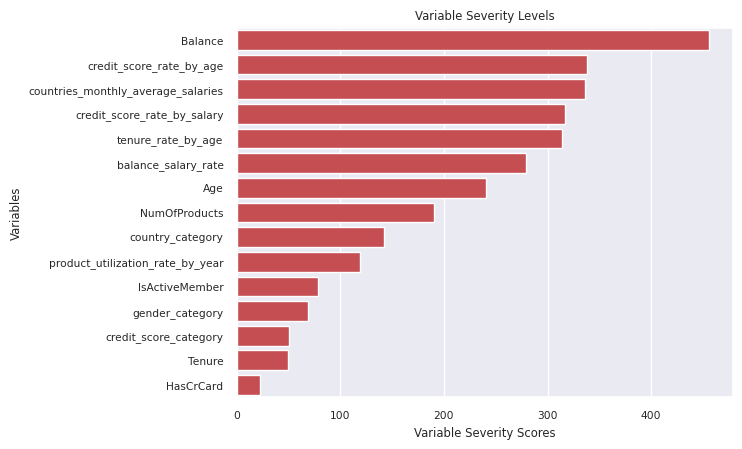

In [ ]:
feature_index = df_encoded.loc[:, df_encoded.columns != dependent_variable_name]

feature_importance = pd.Series(
    lgbm_model.feature_importances_,
    index=feature_index.columns
)
feature_importance = feature_importance.sort_values(ascending=False)

sns.barplot(
    x=feature_importance,
    y=feature_importance.index,
    color='r',
    saturation=1
)

plt.xlabel('Variable Severity Scores')
plt.ylabel('Variables')
plt.title('Variable Severity Levels')
plt.show()

# 13.&nbsp;Conclusion



In [ ]:
# 1. Storytell setiap bagian 1 - 7
# 2. Model Hyperparameter Tuning, untuk mencari model terbaik (Sesuai diskusi: Recall Tinggi,
# FN yang kecil)

In [ ]:
print(df.columns)

Index(['CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age',
       'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'Exited'],
      dtype='object')


# STORYTELLING

Mengoptimalkan Retensi Pelanggan dengan Machine Learning: Storytelling Tentang Churn Modelling

1. Load Dataset:
Memuat dataset yang disebut churn_modelling_dataset. Dataset ini berisi informasi tentang pelanggan, termasuk detail seperti skor kredit, geografi, jenis kelamin, usia, saldo, serta yang terpenting, apakah mereka stop subskripsi atau tidak. Disini saya mengobservasi data dari kepala sampai ekor data. (df.head, df.tail)

2. Data Preparation : Outliers Observe & Data Analysis:
Setelah memuat dataset, dilakukan persiapan data dan analisis awal. Saya mencoba menemukan outlier dengan metode LOF yang mencari potensi outlier dengan mencari data dengan nilai yang cenderung rendah. Setelah menemukan outlier, saya pun menganalisis data dengan memetakan distribusi kolom numerik serta mengobservasi variabel yang bergantung pada variabel dependen. Analisis ini memberi saya wawasan tentang karakteristik data dan membantu mempersiapkan langkah-langkah berikutnya.

3. Feature Engineering:
Ketika sudah memiliki gambaran serta data yang 'bersih', saya kemudian lanjut untuk mempersiapkan dengan melakukan feature engineering. Disini terbit kesempatan untuk membuat fitur tambahan, menggabungkan atau mengubah fitur yang ada, serta mengekstraksi informasi baru dari data mentah kami. Contohnya disini saya membuat fungsi yang memetakan nilai credit_score manjadi 6 kategori. Ini memungkinkan pengguna untuk menangkap kompleksitas yang mungkin tersembunyi dalam dataset churn.

4. Data Encoding:
Setelah kompleksitas data terlihat lebih jelas, saya menemukan bahwa beberapa fitur dalam dataset adalah kategorikal, maka dari itu disini saya lakukan encoding untuk mengubahnya menjadi bentuk yang dapat diproses oleh model machine learning. Contohnya, disini saya menggunakan one-hot encoding untuk menjaga informasi dari fitur kategorikal tersebut.

5. Model Preparation:
Pada saat data sudah siap untuk diprediksi, saya mempersiapkan model untuk proses klasifikasi churn. Saya memilih beberapa algoritma machine learning yang sesuai dengan kasus dataset, seperti RandomForestClassifier, XGBClassifier, dan LGBMClassifier. Proses persiapan model mencakup pembuatan model serta data training. Untuk meyakinkan pengguna, data training juga didampingi dengan menghasilkan nilai akurasi model, yang dihitung sebagai jumlah prediksi yang benar (true positive dan true negative) dibagi dengan jumlah total sampel. presisi, serta recall, yaitu seberapa banyak dari keseluruhan sampel positif yang benar-benar diprediksi dengan benar oleh model (true positive).

6. Helper Functions:
Setelah model menghasilkan hasil prediksi dengan akurasi yang baik, disini saya membuat fungsi helper yang memudahkan proses pengembangan dan evaluasi model, kami membuat beberapa fungsi bantu. Ini termasuk fungsi untuk melatih model, melakukan prediksi, menampilkan metrik evaluasi, serta memvisualisasikan confusion matrix yang semua tujuannya adalah memperjelas gambaran data.

7. Data Cleaning:
Setelah membuahkan dataset yang bersih dan model yang akurat, saya melakukan data cleaning terakhir dengan mengecek data dan melihat apabila masih ada missing values. Saya kemudian melakukan feature engineering dan encoding kepada data yang tidak memiliki missing values, dan memvisualisasikan data dengan heatmap. Alhasil, heatmap yang dihasilkan merupakan heatmap dengan warna yang lebih rata secara menyeluruh.

# [Misc.] LOF Visually Explained

In [ ]:
import numpy as np

# Create synthetic dataset
np.random.seed(42)
X_inliers = 0.3 * np.random.randn(100, 2)
X_inliers = np.r_[X_inliers + 2, X_inliers - 2]
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))
X = np.r_[X_inliers, X_outliers]
n_outliers = len(X_outliers)
ground_truth = np.ones(len(X), dtype=int)
ground_truth[-n_outliers:] = -1

In [ ]:
dataset = pd.DataFrame(
    data={
        'X1': X[:, 0],
        'X2': X[:, 1],
        'ground_truth': ground_truth
    }
)
dataset

,X1,X2,ground_truth
0,2.15,1.96,1
1,2.19,2.46,1
2,1.93,1.93,1
3,2.47,2.23,1
4,1.86,2.16,1
5,1.86,1.86,1
6,2.07,1.43,1
7,1.48,1.83,1
8,1.70,2.09,1
9,1.73,1.58,1


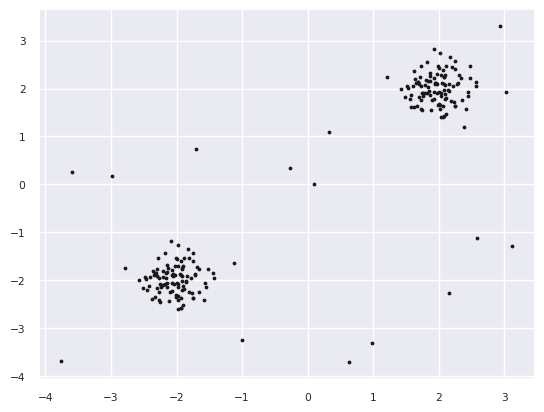

In [ ]:
plt.scatter(
    X[:, 0], X[:, 1],
    color="k", s=3.0,
    label="Data points"
);

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
y_pred = clf.fit_predict(X)
n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_

In [ ]:
dataset['negative_outlier_factor_'] = X_scores
dataset['prediction'] = y_pred
dataset

,X1,X2,ground_truth,negative_outlier_factor_,prediction
0,2.15,1.96,1,-1.00,1
1,2.19,2.46,1,-1.14,1
2,1.93,1.93,1,-0.97,1
3,2.47,2.23,1,-1.29,1
4,1.86,2.16,1,-0.96,1
5,1.86,1.86,1,-0.97,1
6,2.07,1.43,1,-1.17,1
7,1.48,1.83,1,-1.18,1
8,1.70,2.09,1,-1.01,1
9,1.73,1.58,1,-1.15,1


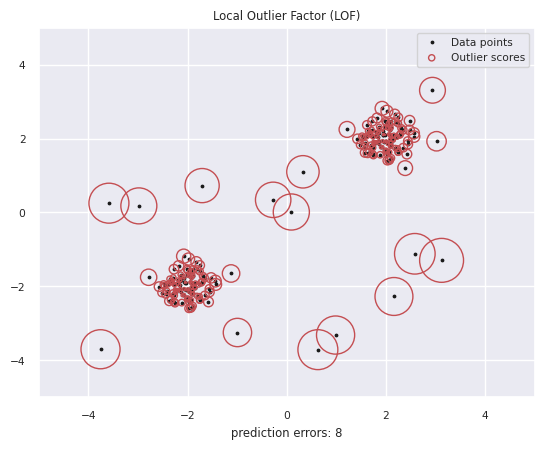

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerPathCollection

def update_legend_marker_size(handle, orig):
    "Customize size of the legend marker"
    handle.update_from(orig)
    handle.set_sizes([20])

plt.scatter(
    X[:, 0], X[:, 1],
    color="k", s=3.0,
    label="Data points"
)

# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())

scatter = plt.scatter(
    X[:, 0], X[:, 1],
    s=1000 * radius, edgecolors="r",
    facecolors="none", label="Outlier scores",
)

plt.axis("tight")
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.xlabel("prediction errors: %d" % (n_errors))
plt.legend(
    handler_map={
        scatter: HandlerPathCollection(update_func=update_legend_marker_size)
    }
)
plt.title("Local Outlier Factor (LOF)")
plt.show()

In [ ]:
dataset['radius'] = radius
dataset

,X1,X2,ground_truth,negative_outlier_factor_,prediction,radius
0,2.15,1.96,1,-1.00,1,0.01
1,2.19,2.46,1,-1.14,1,0.03
2,1.93,1.93,1,-0.97,1,0.00
3,2.47,2.23,1,-1.29,1,0.05
4,1.86,2.16,1,-0.96,1,0.00
5,1.86,1.86,1,-0.97,1,0.00
6,2.07,1.43,1,-1.17,1,0.03
7,1.48,1.83,1,-1.18,1,0.03
8,1.70,2.09,1,-1.01,1,0.01
9,1.73,1.58,1,-1.15,1,0.03


$$ reach-dist(p, o) = \max(\text{dist}(p, o), \text{k-distance}(o)) $$

$$ lrd(p) = \frac{1}{\frac{\sum_{o \in N_k(p)}{\text{reach-dist}(p, o)}}{|N_k(p)|}} $$

$$
\text{LOF}(p) = \frac{\sum_{o \in N_k(p)}{\frac{\text{lrd}(o)}{\text{lrd}(p)}}}{|N_k(p)|}
$$


\